# Project - Regressors

## Initialization

Import libraries

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, r2_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support, precision_recall_curve, auc

from operator import itemgetter, attrgetter

from matplotlib import pyplot as plt

#### Prepare parallel kernel

*Install [here](https://ipyparallel.readthedocs.io/en/latest/), define the number of engines and click '**Start**' in the* **iPython Clusters** *tab.*

Import parallel computing libraries and register processors

In [2]:
from ipyparallel import Client
from ipyparallel.joblib import IPythonParallelBackend
from joblib import Parallel, parallel_backend, register_parallel_backend

In [3]:
c = Client(profile='default')
print('profile:', c.profile)
print("IDs:", c.ids) # Process id numbers
bview = c.load_balanced_view()
register_parallel_backend('ipyparallel',
                          lambda : IPythonParallelBackend(view=bview))

profile: default
IDs: [0, 1, 2]


---

## Function definitions

Read datasets

In [4]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,5))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    ax = sns.barplot(y,x,orient="h");
    plt.xlabel("Importance fraction", fontsize = 12)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(x,labels, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    plt.show()

In [5]:
def pp_rf(test_size):
    
    list_of_files = glob.glob('50_by_100/Full*.csv') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    
    print(latest_file)

    df_raw = pd.read_csv(latest_file, index_col=0)
    df_raw.sort_index(inplace = True, ascending = True)
    df_raw.sort_index(inplace = True, axis = 1)

    y = df_raw.COVID.copy()
    X = df_raw.drop(columns = ['COVID']).copy()
    
    X_types = dict(X.dtypes)
    features = list(X.columns)
    
    train = np.random.rand(len(df_raw))> test_size

    X_train = X[train]
    X_test = X[~train]

    y_train = y[train].tolist()
    y_test = y[~train].tolist()

    return X, X_train, X_test, y, y_train, y_test

## Random Forest Classifier

We will compare two methods, which are grid search and random search.

In [6]:
X, X_train, X_test, y, y_train, y_test = pp_rf(0.3)

50_by_100\Full-2020_05_09-13_41_43-X_raw_disease_50_target_100_500_by_101.csv


In [7]:
clf = RandomForestRegressor(n_jobs=-1)

### Grid search

To avoid having too high a computational time, we will focus on 2 of the mot important parameters that are max depth and the number of estimators.

#### Max Depth

This parameter is the depth of the trees, which is one of the most important. We range it between 4 (anything lower seems too low and increases computational time without much results) and 15.

#### Number of estimators

This parameter is the number of trees that are going to be generated. Here the choice of the number of trees will mostly affect the computational time. Let's set the values between 100 and 5'000 and see the effects.

In [8]:
max_depth = list(range(4,16))

In [9]:
n_estimators = [100, 200, 500, 1000, 2000]

Let's use the default 5 folds of cross validation.

In [10]:
grid_parameters = {'max_depth' : max_depth, 'n_estimators' : n_estimators }

In [11]:
grid_clf = GridSearchCV(clf, param_grid = grid_parameters, return_train_score=True, verbose = 3)

In [12]:
print(X_train.shape)
print(len(y_train))

(380, 100)
380


In [13]:
with parallel_backend('ipyparallel'):
    grid_clf.fit(X_train, y_train);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


Let's check which model is the best.

In [14]:
grid_best_score = grid_clf.best_score_
grid_best_parameters = grid_clf.best_params_
grid_best_max_depth = grid_best_parameters.get('max_depth')
grid_best_n_estimators = grid_best_parameters.get('n_estimators')

print('Grid search best_score: {:.5}'.format(grid_best_score))
print('Best_max_depth: {}'.format(grid_best_max_depth))
print('Best_n_estimators: {}'.format(grid_best_n_estimators))

Grid search best_score: -1.2991
Best_max_depth: 12
Best_n_estimators: 100


In [15]:
grid_clf_best = RandomForestRegressor(n_jobs = -1,max_depth = grid_best_max_depth, n_estimators = grid_best_n_estimators )

In [16]:
grid_clf_best.fit(X_train, y_train);

Let's apply it to our validation set.

In [17]:
grid_y_pred = grid_clf_best.predict(X_test)

In [18]:
mape = abs(grid_y_pred - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mape)))

Accuracy: -265.94%


Given this accuracy, we can take a deeper look into the results.

grid_cm = confusion_matrix(y_test, grid_y_pred)
index = ['Negative','Positive']  
columns = ['Negative','Positive']  
cm_df = pd.DataFrame(grid_cm,columns,index) 


plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the grid search', fontsize = 15);

#### Feature importance

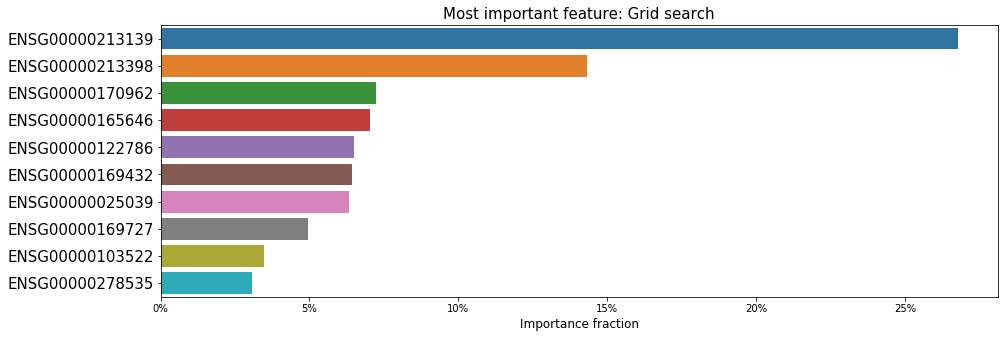

In [19]:
grid_feature_importances = [(list(X.columns)[i], grid_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
grid_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(grid_feature_importances, 10, 'Grid search')

In [20]:
print(r2_score(y_test,grid_y_pred))

-0.25086036253318844


#### Feature selection

Let's try to run the model again, but this time selecting only the most impacting features to save us some work and let's compare the results.

In [21]:
grid_selected_features = [grid_feature_importances[i][0] for i in range(15)]
grid_X_train_sel = X_train[grid_selected_features]
grid_X_test_sel = X_test[grid_selected_features]

In [22]:
with parallel_backend('ipyparallel'):
    grid_clf.fit(grid_X_train_sel, y_train);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


In [23]:
grid_best_score_sel = grid_clf.best_score_
grid_best_parameters_sel = grid_clf.best_params_
grid_best_max_depth_sel = grid_best_parameters.get('max_depth')
grid_best_n_estimators_sel = grid_best_parameters.get('n_estimators')
print('Grid search best_score with selected features: {:.5}'.format(grid_best_score_sel))
print('Grid search best_max_depth with selected features: {}'.format(grid_best_max_depth_sel))
print('Grid search best_n_estimators with selected features: {}'.format(grid_best_n_estimators_sel))

Grid search best_score with selected features: -1.0692
Grid search best_max_depth with selected features: 12
Grid search best_n_estimators with selected features: 100


In [24]:
grid_clf_best_sel = RandomForestRegressor(n_jobs = -1,
                                          max_depth = grid_best_max_depth_sel,
                                          n_estimators = grid_best_n_estimators_sel)

In [25]:
grid_clf_best_sel.fit(grid_X_train_sel, y_train);

In [26]:
grid_y_pred_sel = grid_clf_best_sel.predict(grid_X_test_sel)

In [27]:
mape = abs(grid_y_pred_sel - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mape)))

Accuracy: -262.33%


In [28]:
print(r2_score(y_test,grid_y_pred_sel))

-0.2556040905074686


### Random Search

After having explored a grid search, we can adopt another approach. Instead of searching for each value, let's give our model more parameters input, but instead let it choose randomly at each iteration one value for each parameter. It will then be evaluated again.

In [29]:
n_estimators = range(10,1000,50)
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]
bootstrap = [True,False]
max_depth = range(5,50,10)
min_samples_leaf = range(2,100, 2)
min_samples_split = range(2,100,2)

random_parameters = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_leaf':
              min_samples_leaf}


In [30]:
random_clf = RandomizedSearchCV(clf, param_distributions = random_parameters, n_iter = 20, verbose = 3)

In [31]:
with parallel_backend('ipyparallel'):
    random_clf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


In [32]:
random_best_score = random_clf.best_score_
print('Random search best_score: {:.4}'.format(random_best_score))


Random search best_score: -0.5478


In [33]:
random_best_parameters = random_clf.best_params_
random_best_n_estimators = random_best_parameters.get('n_estimators')
random_best_min_samples_leaf = random_best_parameters.get('min_samples_leaf')
random_best_max_features = random_best_parameters.get('max_features')
random_best_max_depth = random_best_parameters.get('max_depth')

print('Best_n_estimators: {}'.format(random_best_n_estimators))
print('Best_min_samples_leaf: {}'.format(random_best_min_samples_leaf))
print('Best_max_features: {}'.format(random_best_max_features))
print('Best_max_depth: {}'.format(random_best_max_depth))


Best_n_estimators: 210
Best_min_samples_leaf: 14
Best_max_features: log2
Best_max_depth: 35


In [34]:
random_clf_best = RandomForestRegressor(n_jobs = -1,
                                        n_estimators = random_best_n_estimators,
                                        min_samples_leaf = random_best_min_samples_leaf,
                                        max_features = random_best_max_features,
                                        max_depth = random_best_max_depth)

In [35]:
random_clf_best.fit(X_train, y_train);

In [36]:
random_y_pred = random_clf_best.predict(X_test)

random_cm = confusion_matrix(y_test, random_y_pred)
annot_kws = {"ha": 'center',"va": 'center'}


plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

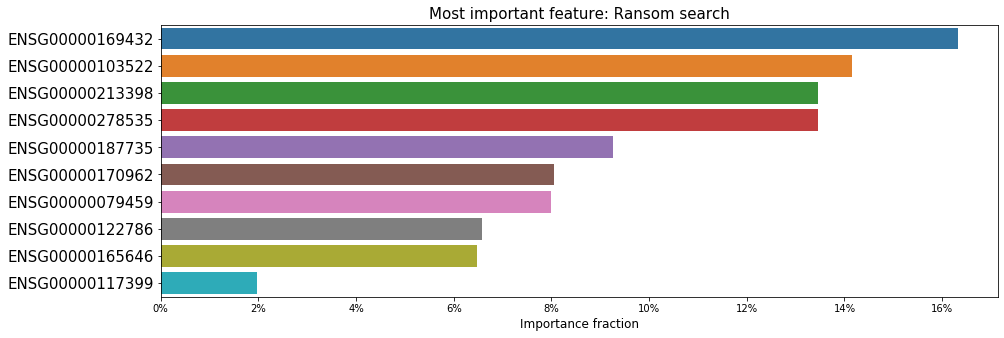

In [37]:
random_feature_importances = [(list(X.columns)[i], random_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
random_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(random_feature_importances, 10, 'Ransom search')

In [38]:
print(r2_score(y_test,random_y_pred))

0.0013314049489027147


In [39]:
random_mae = 100 * abs(random_y_pred - y_test)/y_test
print("Accuracy: {:.2%}".format(100 - np.mean(mape)))

Accuracy: -25544.52%


### Comparison

#### ROC Curve

fpr_grid, tpr_grid, _ = roc_curve(y_test, grid_y_pred)
fpr_grid_sel, tpr_grid_sel, _ = roc_curve(y_test, grid_y_pred_sel)
fpr_random, tpr_random, _ = roc_curve(y_test, random_y_pred)

plt.figure(figsize=(12, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

roc_auc_grid = roc_auc_score(y_test, grid_y_pred)
print('ROC AUC for Grid Search: %.5f' % roc_auc_grid)
roc_auc_grid_sel = roc_auc_score(y_test, grid_y_pred_sel)
print('ROC AUC for Grid Search with selected predictors: %.5f' % roc_auc_grid_sel)
roc_auc_random = roc_auc_score(y_test, random_y_pred)
print('ROC AUC for Random Search: %.5f' % roc_auc_random)

We observe that all three methods are better than a random prediction. The Grid Search with Selected Predictors has slightly better prediction than the Random Search, which has in turn slightly better prediction than the basic Grid Search.

plt.figure(figsize=(12, 6))
plt.xlim(0.05, 0.15)
plt.ylim(0.4, 0.55)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##### Precision - Recall Curve

grid_precision, grid_recall, _ = precision_recall_curve(y_test, grid_y_pred)
grid_precision_sel, grid_recall_sel, _ = precision_recall_curve(y_test, grid_y_pred_sel)
random_precision, random_recall, _ = precision_recall_curve(y_test, random_y_pred)

y_test = np.array(y_test)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.figure(figsize=(12, 6))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(grid_recall, grid_precision, marker='.', label='Grid Search')
plt.plot(grid_recall_sel, grid_precision_sel, marker='.', label='Grid Search')
plt.plot(random_recall, random_precision, marker='.', label='Random Search')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

pr_auc_grid = auc(grid_recall, grid_precision)
print('Precision-Recall AUC for Grid Search: %.5f' % pr_auc_grid)
pr_auc_grid_sel = auc(grid_recall_sel, grid_precision_sel)
print('Precision-Recall AUC for Grid Search with selected predictors: %.5f' % pr_auc_grid_sel)
pr_auc_random = auc(random_recall, random_precision)
print('Precision-Recall AUC for Random Search: %.5f' % pr_auc_random)